# Current Strategy

## Importing Libraries

In [74]:
import ta
import pandas as pd
import scipy
import numpy as np
import sklearn
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()

## Read in the Data

### From Local Device

<AxesSubplot:>

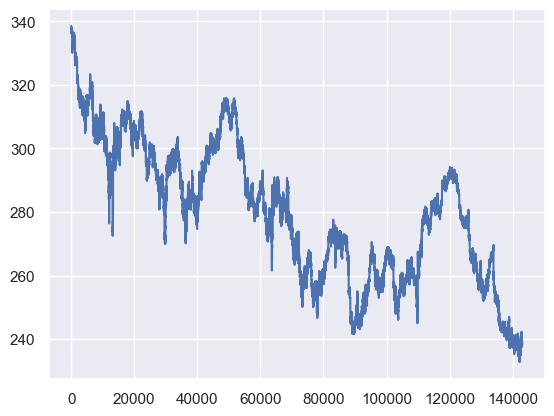

In [99]:
df = pd.read_csv("Data/MSFT 2022 Minute data.csv")
df = df.rename(columns={"open": "Open", "high": "High","low": "Low", "volume": "Volume", "close": "Close"})
df = df.iloc[:143000]
df['Close'].plot()

### From Alpaca

In [386]:
import alpaca_trade_api as tradeapi
import pandas as pd

api_key = 'PKGASCZ8VKFX6R99BYS7'
api_secret = 'M8BNGX7Y8e28DJyNaau9bTggM3AZPIURgFHKAMBc'
base_url = 'https://paper-api.alpaca.markets'  # or use https://api.alpaca.markets for live trading
rest_client = REST(api_key, api_secret, base_url)
# api = tradeapi.REST(api_key, api_secret, base_url)

symbol = 'TSLA'
timeframe = '1Min'
start_date = '2021-01-01'
end_date = '2021-12-31'

spy_df = rest_client.get_bars(symbol, timeframe, start=start_date, end=end_date).df

df = spy_df
df = df.reset_index()
df = df.rename(columns={"open": "Open", "high": "High","low": "Low", "trade_count": "Volume", "close": "Close", "timestamp": "ts_event"})
print(symbol)
df

TSLA


,ts_event,Open,High,Low,Close,volume,Volume,vwap
0,2021-01-04 09:00:00+00:00,709.00,714.0000,709.00,714.00,16573,378,710.697591
1,2021-01-04 09:01:00+00:00,716.98,721.0000,716.98,720.15,11263,536,719.496094
2,2021-01-04 09:02:00+00:00,721.00,723.8800,721.00,722.50,13591,556,721.996966
3,2021-01-04 09:03:00+00:00,722.97,723.1000,722.97,723.10,5215,211,723.250585
4,2021-01-04 09:04:00+00:00,724.00,725.0000,724.00,725.00,7640,334,724.439424
...,...,...,...,...,...,...,...,...
185664,2022-01-01 00:55:00+00:00,1062.75,1062.7500,1062.75,1062.75,299,15,1062.704415
185665,2022-01-01 00:56:00+00:00,1062.80,1062.9099,1062.50,1062.80,1021,39,1062.702282
185666,2022-01-01 00:57:00+00:00,1062.80,1062.8000,1062.80,1062.80,388,27,1062.711057
185667,2022-01-01 00:58:00+00:00,1062.80,1062.8000,1062.55,1062.55,1373,65,1062.736621


## Implementing the Rolling Sharpe Ratio and the Indicators

In [81]:
threshold = 0.5

In [82]:
# Assuming risk-free rate is negleted
df['Avg_Return'] = df['Close'].pct_change(1)
df['rolling_mean'] = df['Avg_Return'].rolling(window=15).mean()
df['rolling_sd'] = df['Avg_Return'].rolling(window=15).std()
df['Sharpe_Ratio'] = (df['rolling_mean']/df['rolling_sd']) # Unshifted Sharpe Ratio
def sharpeAssign(value):
    if value > threshold:
        return 2
    elif value < -threshold:
        return 1
    else:
        return 0

df['Long_Short_Hold'] = df['Sharpe_Ratio'].apply(sharpeAssign)


### Experimental Features

In [83]:
# Assuming risk-free rate is negleted
df['Avg_Return'] = df['Close'].pct_change(1)
df['rolling_mean'] = df['Avg_Return'].rolling(window=15).mean()
df['rolling_sd'] = df['Avg_Return'].rolling(window=15).std()
df['Sharpe_Ratio'] = (df['rolling_mean']/df['rolling_sd']) # Unshifted Sharpe Ratio


# Plotting
'''
fig=plt.figure() 
a1=fig.add_axes([0,0,1,1]) 
x=np.arange(1,11) 
a1.plot(df['Sharpe_Ratio'][250:800], 'r-') 
# a1.set_ylabel('exp') 
a2=a1.twinx()
a2.plot(df['Close'][250:800])

'''

df['S_RSI'] = ta.momentum.StochRSIIndicator(close = df['Close'],window = 15).stochrsi()

df['MFI'] = ta.volume.MFIIndicator(high = df['High'], low = df['Low'], close = df['Close'], volume = df['Volume'],window = 15).money_flow_index()

df['ATR'] = ta.volatility.AverageTrueRange(high = df['High'], low = df['Low'], close = df['Close'],window = 15).average_true_range()

df['CCI'] = ta.trend.CCIIndicator(high = df['High'], low = df['Low'], close = df['Close'],window = 15).cci()

df

## Buy = 2
## Sell = 1
## Hold = 0

def sharpeAssign(value):
    if value > threshold:
        return 2
    elif value < -threshold:
        return 1
    else:
        return 0

df['Long_Short_Hold'] = df['Sharpe_Ratio'].apply(sharpeAssign)

Target_variables = ['S_RSI', 'MFI', 'ATR', 'CCI']
for variable in Target_variables:
    df.loc[:,variable] = mstats.winsorize(df.loc[:,variable], limits = [0.1,0.1])


In [84]:
df.head()

,Unnamed: 0.1,Unnamed: 0,ts_event,Open,High,Low,Close,Volume,product_id,ticker,Avg_Return,rolling_mean,rolling_sd,Sharpe_Ratio,Long_Short_Hold,S_RSI,MFI,ATR,CCI
0,0,6,2022-01-03 09:00:00,338.10,338.10,338.10,338.10,5,7119,MSFT,NaN,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386
1,1,16,2022-01-03 09:01:00,338.10,338.10,338.00,338.09,13,7119,MSFT,-0.000030,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386
2,2,29,2022-01-03 09:02:00,338.09,338.17,338.09,338.17,20,7119,MSFT,0.000237,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386
3,3,40,2022-01-03 09:03:00,338.33,338.53,338.30,338.53,471,7119,MSFT,0.001065,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386
4,4,51,2022-01-03 09:04:00,338.57,338.57,338.00,338.00,389,7119,MSFT,-0.001566,NaN,NaN,NaN,0,1.0,78.695286,0.093608,137.31386


### PCA Features

In [59]:
df = dropna(df)
df.shape

(5965, 15)

In [63]:
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# df = dropna(df)

# Add all technical features
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Take the value columnes
old_space = df.iloc[:,3:]
old_space = old_space.drop('ticker', axis = 1)



/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [64]:
old_space.shape
# old_space.head()
# old_space.iloc[680:700,:]

(142986, 97)

In [65]:
mean = list(old_space.mean())
# calculate the mean of each column
column_means = old_space.mean()

# subtract the column means from the dataframe values
old_space_centered = old_space - column_means


In [70]:
old_space_centered.head()
X = old_space_centered
X.dropna()
X.shape

(142986, 97)

In [71]:
# from ta import add_all_ta_features
# from ta.utils import dropna
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import MinMaxScaler

# df = dropna(df)

# # Add all technical features
# df = add_all_ta_features(
#     df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# # Take the value columnes
# old_space = df.iloc[:,3:]
# old_space = old_space.drop('ticker', axis = 1)


# Create a MinMaxScaler object
# scaler = MinMaxScaler()

# Scale the array
# arr_scaled = scaler.fit_transform(old_space)

# Create a 2D array X
# X = arr_scaled

# Instantiate a PCA object with 5 components
pca = PCA(n_components=10)

# Fit and transform the data to get the first 5 principal components
X_pca = pca.fit_transform(X)

pd_new = pd.DataFrame(X_pca)
pd_new['Sharpe_Ratio'] = df['Sharpe_Ratio']
pd_new['Long_Short_Hold'] = df['Long_Short_Hold']
pd_new['Close'] = df['Close']
pd_new['ts_event'] = df['ts_event']
pd_new

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [107]:
Target_variables = [0,1,2,3]
df = pd_new
for variable in Target_variables:
    df.loc[:,variable] = mstats.winsorize(df.loc[:,variable], limits = [0.1,0.1])

<AxesSubplot:>

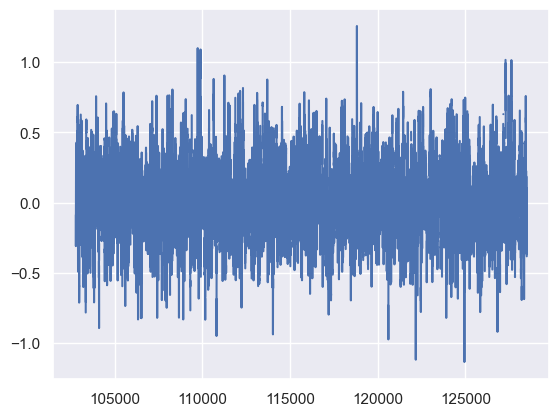

In [108]:
df['Sharpe_Ratio'][end_train:end_test].plot()

## A dictionary to convert time ticks into date time

In [85]:
time_lookup = {}
temp = [[i,j] for i,j in zip(df.index, df["ts_event"])]
for k in temp:
    time_lookup[k[0]] = k[1]
# time_lookup

## A position class to keep track of the balance

In [86]:
class position():
    def __init__(self):
        self.balance = 3000
        self.volume = 0

    def buy(self,sr):
        '''
        take in a sharpe ratio that's greater than the threshold, 
        we find the close price and buy 1 share of it
        '''
        self.volume += 1 # this can be adjusted further
        index = df[abs(df['Sharpe_Ratio'] - sr) < 0.000001].index[0]
        self.balance -= df['Close'][index] # subtract the price
        print("buy at " + str(df['Close'][index]) + " at t = " + str(index))

    def buyati(self,i):
        '''
        buy 1 share at the close price at index i
        '''
        self.volume += 1 # this can be adjusted further
        self.balance -= df['Close'][i] # subtract the price
        print("buy at " + str(df['Close'][i]) + " at t = " + str(i))

    def sell(self,sr):
        '''
        take in a sharpe ratio that's less than the threshold, 
        we find the close price and sell 1 share of it
        '''
        self.volume -= 1 # this can be adjusted further
        index = df[abs(df['Sharpe_Ratio'] - sr) < 0.000001].index[0]
        self.balance += df['Close'][index] # add the price 
        print("sell at " + str(df['Close'][index]) + " at t = " + str(index))

    def sellati(self,i):
        '''
        sell 1 share at the close price at index i
        '''
        self.volume -= 1 # this can be adjusted further
        self.balance += df['Close'][i] # subtract the price
        print("sell at " + str(df['Close'][i]) + " at t = " + str(i))

    def finalBalance(self, time):
        '''
        sell all positions and look at profit
        '''
        self.balance += self.volume * df['Close'][time]
        self.volume = 0
        return self.balance + self.volume * df['Close'][time]


In [87]:
Izzy = position()
start, finish = 0, len(df)-1
shop = list(df['Sharpe_Ratio'][start:finish])
for i in shop:
    if i > 1:
        Izzy.buy(i)
    if i < -1:
        Izzy.sell(i)
Izzy.finalBalance(finish)

# Stephen = position()
# start, finish = 0, len(df)-1
# shop = list(df['Sharpe_Ratio'][start:finish])
# for i in shop:
#     if i > 0.9:
#         Stephen.buy(i)
#     if i < -0.9:
#         Stephen.sell(i)
# Stephen.finalBalance(finish)

Mia = position()
start, finish = 0, len(df)-1
shop = list(df['Sharpe_Ratio'][start:finish])
for i in shop:
    if i > 0.5:
        Mia.buy(i)
    if i < -0.5:
        Mia.sell(i)
Mia.finalBalance(finish)

print(Izzy.balance, Mia.balance)

sell at 330.1 at t = 312
sell at 330.24 at t = 313
sell at 330.07 at t = 314
sell at 329.925 at t = 1157
sell at 329.44 at t = 1158
sell at 301.47 at t = 10471
buy at 302.83 at t = 10675
sell at 309.95 at t = 18374
sell at 309.9 at t = 18375
sell at 309.76 at t = 18376
sell at 309.5 at t = 18377
sell at 309.44 at t = 18378
sell at 309.4 at t = 18379
sell at 309.22 at t = 18380
buy at 299.73 at t = 19536
sell at 281.92 at t = 30060
sell at 295.55 at t = 34108
sell at 295.43 at t = 34110
buy at 291.67 at t = 34681
buy at 291.78 at t = 34682
buy at 291.78 at t = 34683
sell at 289.54 at t = 34709
buy at 293.26 at t = 41360
buy at 293.65 at t = 41361
buy at 294.42 at t = 41362
buy at 300.55 at t = 43165
sell at 310.66 at t = 52238
buy at 301.18 at t = 53562
sell at 282.15 at t = 56251
sell at 281.65 at t = 56252
sell at 286.99 at t = 57451
sell at 280.08 at t = 58479
sell at 279.99 at t = 58480
sell at 280.05 at t = 58481
sell at 279.94 at t = 58482
sell at 279.83 at t = 58483
sell at 279.0

sell at 301.33 at t = 10835
sell at 301.3 at t = 10837
sell at 300.75 at t = 10950
sell at 300.69 at t = 10951
sell at 300.35 at t = 10952
sell at 300.1 at t = 10953
sell at 300.09 at t = 10954
sell at 298.16 at t = 10995
sell at 297.96 at t = 11023
sell at 297.91 at t = 11024
buy at 302.2 at t = 11038
buy at 302.05 at t = 11039
buy at 301.8 at t = 11040
sell at 299.35 at t = 11207
sell at 311.23 at t = 3617
sell at 299.67 at t = 11209
sell at 298.63 at t = 11306
sell at 298.29 at t = 11307
sell at 298.2 at t = 11308
sell at 298.08 at t = 11309
sell at 298.1 at t = 11310
sell at 298.33 at t = 11311
sell at 298.21 at t = 11312
sell at 297.59 at t = 11313
sell at 296.56 at t = 11357
sell at 295.89 at t = 11358
buy at 295.27 at t = 11487
buy at 298.24 at t = 11568
sell at 296.65 at t = 11597
sell at 296.42 at t = 11600
sell at 296.35 at t = 11601
sell at 295.7 at t = 11602
sell at 295.64 at t = 11603
sell at 295.5 at t = 11604
sell at 295.3 at t = 11605
buy at 297.03 at t = 11699
buy at 2

sell at 295.24 at t = 25822
sell at 295.37 at t = 25823
sell at 294.34 at t = 25824
sell at 294.09 at t = 25825
sell at 294.25 at t = 25826
sell at 294.04 at t = 25827
buy at 296.39 at t = 25952
buy at 296.69 at t = 25953
buy at 296.88 at t = 25954
buy at 297.09 at t = 25955
buy at 296.93 at t = 25956
buy at 297.15 at t = 25957
buy at 297.22 at t = 25958
buy at 297.18 at t = 25959
sell at 295.98 at t = 25972
buy at 296.48 at t = 26031
buy at 296.52 at t = 26032
buy at 299.75 at t = 26105
buy at 303.5 at t = 14953
buy at 299.82 at t = 26136
buy at 300.195 at t = 26137
buy at 300.85 at t = 26138
sell at 297.33 at t = 26277
sell at 296.9 at t = 26278
sell at 295.95 at t = 26495
sell at 295.86 at t = 26497
sell at 294.83 at t = 26558
sell at 294.68 at t = 26559
sell at 294.59 at t = 26560
sell at 294.73 at t = 26561
sell at 294.88 at t = 26564
sell at 294.95 at t = 26565
sell at 294.55 at t = 26566
sell at 293.59 at t = 26587
sell at 293.71 at t = 26696
sell at 293.38 at t = 26697
sell at 

buy at 299.6 at t = 42893
buy at 299.69 at t = 42894
buy at 299.58 at t = 42896
buy at 299.62 at t = 42897
buy at 299.64 at t = 42898
buy at 299.88 at t = 43161
buy at 300.09 at t = 43162
buy at 300.21 at t = 43163
buy at 300.43 at t = 43164
buy at 300.55 at t = 43165
buy at 300.4 at t = 43171
sell at 299.71 at t = 43192
sell at 299.64 at t = 43193
sell at 299.61 at t = 43194
sell at 299.5 at t = 43195
sell at 299.49 at t = 43196
sell at 299.44 at t = 43197
sell at 299.49 at t = 43198
sell at 299.46 at t = 43199
sell at 299.48 at t = 43200
sell at 299.43 at t = 43201
sell at 297.15 at t = 43404
buy at 297.21 at t = 43445
buy at 297.16 at t = 43446
buy at 296.6 at t = 43624
buy at 297.34 at t = 43667
buy at 297.55 at t = 43672
buy at 297.61 at t = 43673
buy at 297.56 at t = 43674
buy at 297.48 at t = 43675
buy at 299.22 at t = 43767
buy at 299.32 at t = 43768
buy at 299.6 at t = 43769
buy at 299.45 at t = 43770
buy at 299.4 at t = 43771
buy at 299.36 at t = 43772
buy at 299.5 at t = 437

sell at 280.08 at t = 58479
sell at 279.99 at t = 58480
sell at 280.05 at t = 58481
sell at 279.94 at t = 58482
sell at 279.83 at t = 58483
sell at 280.0 at t = 58484
sell at 280.01 at t = 58485
sell at 279.07 at t = 58537
sell at 278.94 at t = 58538
sell at 279.03 at t = 58539
sell at 278.84 at t = 58542
buy at 280.31 at t = 58610
buy at 280.44 at t = 58611
buy at 280.45 at t = 58612
buy at 280.51 at t = 58613
buy at 280.445 at t = 58614
buy at 280.65 at t = 58615
buy at 280.63 at t = 58616
buy at 280.525 at t = 58617
buy at 280.57 at t = 58618
buy at 280.68 at t = 58619
buy at 280.79 at t = 58620
buy at 280.63 at t = 58621
sell at 279.14 at t = 58732
sell at 279.01 at t = 58733
sell at 279.08 at t = 58737
sell at 278.74 at t = 58742
buy at 280.81 at t = 58757
buy at 280.61 at t = 58758
buy at 280.74 at t = 58759
buy at 281.26 at t = 58760
buy at 281.33 at t = 58761
buy at 281.79 at t = 58762
buy at 281.88 at t = 58763
buy at 281.65 at t = 58764
buy at 281.4 at t = 58765
sell at 279.4

buy at 261.13 at t = 74517
buy at 261.09 at t = 74519
buy at 261.68 at t = 74520
buy at 262.0 at t = 74521
sell at 260.65 at t = 74536
sell at 260.37 at t = 74541
sell at 260.2 at t = 74543
buy at 259.0 at t = 74675
buy at 258.8 at t = 74676
buy at 263.03 at t = 74812
buy at 263.24 at t = 74813
buy at 263.31 at t = 74817
buy at 263.44 at t = 74818
buy at 263.72 at t = 74822
buy at 265.28 at t = 74868
buy at 265.26 at t = 74870
buy at 265.35 at t = 74871
buy at 265.33 at t = 74872
buy at 265.2 at t = 74873
buy at 265.52 at t = 74876
sell at 262.09 at t = 74921
buy at 265.29 at t = 75073
buy at 266.79 at t = 75154
sell at 263.73 at t = 75406
sell at 263.61 at t = 75407
sell at 263.31 at t = 75408
sell at 263.23 at t = 75409
sell at 263.25 at t = 75410
sell at 262.97 at t = 75411
sell at 263.01 at t = 75412
sell at 263.12 at t = 75413
sell at 263.06 at t = 75414
sell at 262.66 at t = 75415
sell at 262.77 at t = 75416
sell at 262.99 at t = 75417
sell at 262.87 at t = 75418
buy at 265.04 at

buy at 245.71 at t = 89079
buy at 245.845 at t = 89081
sell at 245.31 at t = 89090
sell at 245.18 at t = 89091
sell at 245.23 at t = 89092
sell at 283.64 at t = 60949
sell at 244.83 at t = 89095
sell at 244.74 at t = 89096
sell at 244.66 at t = 89097
sell at 244.75 at t = 89098
sell at 244.6 at t = 89099
sell at 244.34 at t = 89100
sell at 244.46 at t = 89101
sell at 244.56 at t = 89102
sell at 244.4 at t = 89103
sell at 243.81 at t = 89142
sell at 243.58 at t = 89145
sell at 243.43 at t = 89335
sell at 243.33 at t = 89337
sell at 244.5 at t = 89404
sell at 244.21 at t = 89406
sell at 243.56 at t = 89453
sell at 242.4 at t = 89728
sell at 242.18 at t = 89734
buy at 244.08 at t = 89837
buy at 244.13 at t = 89838
buy at 244.44 at t = 89842
buy at 245.55 at t = 89859
sell at 244.3 at t = 89879
sell at 244.34 at t = 89880
sell at 244.04 at t = 89881
sell at 243.82 at t = 89884
sell at 243.62 at t = 89885
sell at 243.64 at t = 89886
sell at 243.49 at t = 89889
sell at 243.54 at t = 89890
se

sell at 256.03 at t = 102436
sell at 256.02 at t = 102437
sell at 255.85 at t = 102438
sell at 255.87 at t = 102439
sell at 255.83 at t = 102440
sell at 255.8 at t = 102441
sell at 255.7 at t = 102442
sell at 255.73 at t = 102443
sell at 255.68 at t = 102444
sell at 255.63 at t = 102445
sell at 309.28 at t = 22158
sell at 255.57 at t = 102447
sell at 255.47 at t = 102448
sell at 255.49 at t = 102449
sell at 255.45 at t = 102450
sell at 255.49 at t = 102451
sell at 285.38 at t = 55448
sell at 255.19 at t = 102453
sell at 255.2 at t = 102454
sell at 255.17 at t = 102455
sell at 255.16 at t = 102456
sell at 254.96 at t = 102457
sell at 254.95 at t = 102458
sell at 254.76 at t = 102459
sell at 255.83 at t = 102440
sell at 253.78 at t = 102493
sell at 253.53 at t = 102494
sell at 253.67 at t = 102495
sell at 253.46 at t = 102497
buy at 253.955 at t = 102540
buy at 253.97 at t = 102541
buy at 254.05 at t = 102542
buy at 254.94 at t = 102714
sell at 255.01 at t = 102769
sell at 254.7 at t = 1

sell at 278.48 at t = 116792
sell at 278.43 at t = 116793
sell at 278.33 at t = 116794
buy at 279.22 at t = 116817
buy at 279.14 at t = 116819
buy at 279.27 at t = 116820
sell at 279.73 at t = 117047
buy at 281.35 at t = 117061
buy at 281.51 at t = 117062
buy at 281.52 at t = 117063
buy at 281.41 at t = 117064
buy at 281.55 at t = 117065
buy at 281.6 at t = 117067
buy at 281.75 at t = 117068
buy at 280.9 at t = 117185
buy at 281.14 at t = 117186
buy at 281.14 at t = 117187
buy at 281.26 at t = 117188
buy at 281.13 at t = 117189
buy at 282.5 at t = 117219
sell at 281.36 at t = 117250
buy at 283.03 at t = 117313
buy at 283.24 at t = 117456
sell at 288.43 at t = 117653
sell at 287.17 at t = 117724
buy at 289.07 at t = 117746
buy at 289.03 at t = 117747
buy at 289.02 at t = 117748
buy at 288.98 at t = 117750
sell at 288.25 at t = 117832
buy at 288.46 at t = 117903
buy at 288.87 at t = 117936
sell at 288.15 at t = 118000
sell at 288.19 at t = 118001
sell at 288.17 at t = 118002
sell at 288.

sell at 253.72 at t = 131283
sell at 253.7 at t = 131285
buy at 255.86 at t = 131395
buy at 256.33 at t = 131396
buy at 256.27 at t = 131400
buy at 256.27 at t = 131400
buy at 256.29 at t = 131402
buy at 256.2 at t = 131403
sell at 255.84 at t = 131435
sell at 282.04 at t = 38846
sell at 255.37 at t = 131443
sell at 255.42 at t = 131444
sell at 255.47 at t = 131445
buy at 256.58 at t = 131457
buy at 256.83 at t = 131458
buy at 256.89 at t = 131459
buy at 256.94 at t = 131460
buy at 256.89 at t = 131461
buy at 256.96 at t = 131462
buy at 258.21 at t = 131509
buy at 258.07 at t = 131877
buy at 258.81 at t = 131920
buy at 258.75 at t = 131921
buy at 259.83 at t = 131947
buy at 260.12 at t = 131948
buy at 260.27 at t = 131949
buy at 260.215 at t = 131950
buy at 260.36 at t = 131951
sell at 259.05 at t = 131982
sell at 259.09 at t = 131983
sell at 258.15 at t = 132003
sell at 257.84 at t = 132004
sell at 257.65 at t = 132005
sell at 257.29 at t = 132006
sell at 256.94 at t = 132007
sell at 

## Random Forest Regression

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [89]:
end_train = int(len(df)*0.8)
end_test = len(df)-1
print(time_lookup[end_train], time_lookup[end_test])

train_data = df.loc[:end_train,]
test_data = df.loc[end_train:end_test] 
len(train_data), len(test_data)


2022-08-03 19:25:00 2022-09-29 11:19:00


(114401, 28600)

In [90]:
# Train, Test Split

X_train = train_data.loc[:,Target_variables]
Y_train = train_data.loc[:,['Long_Short_Hold']]
X_test = test_data.loc[:,Target_variables]
Y_test = test_data.loc[:,['Long_Short_Hold']]


#Create validation curve for the Random Forest Classifier
# rf = RandomForestClassifier()
# train_scoreNum, test_scoreNum = validation_curve(rf,
#                                 X = X_train[:], y = Y_train.loc[:,'Long_Short_Hold'], 
#                                 param_name = 'n_estimators', 
#                                 param_range = [3,4,7,10,12,15,20,25,30], cv = TimeSeriesSplit(n_splits = 3))

# train_scores_mean = np.mean(train_scoreNum, axis=1)
# train_scores_std = np.std(train_scoreNum, axis=1)
# test_scores_mean = np.mean(test_scoreNum, axis=1)
# test_scores_std = np.std(test_scoreNum, axis=1)

In [91]:
co_data = df.copy()
co_train = co_data[:114400]
co_train = co_train.dropna().copy()
co_train

X_train = co_train.loc[:,Target_variables]

Y_train = co_train.loc[:,['Long_Short_Hold']]

#Define paramters from Validation Curve
params = {'max_depth': [5, 7],
        'max_features': ['sqrt'],
        'min_samples_leaf': [10, 15, 20],
        'n_estimators': [5, 7, 9],
        'min_samples_split':[20, 25, 30]} #Using Validation Curves

rf = RandomForestClassifier()

#Perform a TimeSeriesSplit on the dataset
time_series_split = TimeSeriesSplit(n_splits = 3)


rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 20)

#Fit the random forest with our X_train and Y_train
rf_cv.fit(X_train, Y_train)
        
#Save the fited variable into a Pickle file
# file_loc = f'{os.getcwd()}\\Pickle_Files\\Cluster_'    
# pickle.dump(rf_cv, open(file_loc,'wb'))

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection

/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection

/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection

/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection

/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection

/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/izzyhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7], 'max_features': ['sqrt'],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [20, 25, 30],
                         'n_estimators': [5, 7, 9]},
             verbose=20)

In [96]:
# Predict the classes of the test set
Y_pred = rf_cv.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9567132867132867


In [97]:
import pickle

# open a file to save the pickle data
with open('model.pkl', 'wb') as f:
    # use pickle.dump to save the object to the file
    pickle.dump(rf_cv, f)
    
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [98]:
Izzy = position()

shop = Y_pred
for i in range(len(Y_pred)):
    if Y_pred[i] == 2:
        Izzy.buyati(i+len(train_data))
    if Y_pred[i] == 1:
        Izzy.sellati(i+len(train_data))
Izzy.finalBalance(len(train_data)+len(test_data)-2)


print(Izzy.balance)

sell at 280.3 at t = 114858
sell at 280.29 at t = 114859
sell at 280.79 at t = 115447
sell at 279.47 at t = 115620
sell at 283.25 at t = 116164
sell at 280.46 at t = 116331
sell at 279.83 at t = 117048
sell at 289.13 at t = 118468
sell at 290.83 at t = 119827
sell at 290.75 at t = 119828
sell at 290.42 at t = 119830
sell at 286.87 at t = 122571
sell at 287.04 at t = 122572
sell at 281.07 at t = 123341
sell at 280.68 at t = 123343
sell at 280.55 at t = 123344
sell at 280.46 at t = 123345
sell at 280.15 at t = 123346
sell at 279.86 at t = 123347
sell at 267.65 at t = 126391
sell at 265.32 at t = 126908
sell at 263.62 at t = 127576
sell at 263.96 at t = 127577
sell at 265.0 at t = 128281
sell at 262.48 at t = 128342
sell at 256.43 at t = 129116
sell at 256.52 at t = 129117
sell at 256.16 at t = 129120
sell at 261.13 at t = 129767
sell at 254.22 at t = 130661
sell at 254.35 at t = 130662
sell at 253.77 at t = 130666
sell at 252.57 at t = 130714
sell at 252.55 at t = 130716
sell at 252.52 a

### Unused helpers

In [ ]:
def reduction(U, s, Vt, n):
    temp = [list(i) for i in zip(*U)]
    len(temp), len(temp[0])
    temp = temp[:n]
    U = [list(i) for i in zip(*temp)]
    s = s[:n]
    s = np.diag(s)
    Vt = Vt[:n]
    return np.dot(np.dot(U, s), Vt)

In [ ]:
# old_space = all_data.iloc[60:100,10:54]

import matplotlib.pyplot as plt
plt.imshow(arr_scaled, cmap='gray_r')
plt.title('baseball', fontsize=15, pad=15)
# numpydata.shape
U, s, Vt = np.linalg.svd(arr_scaled)
# old_space.head()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first 2D array in the first subplot
im1 = ax1.imshow(reduction(U, s, Vt, 40), cmap='gray_r')
ax1.set_title('40 singular vlaues')

# Plot the second 2D array in the second subplot
im2 = ax2.imshow(reduction(U, s, Vt, 8), cmap='gray_r')
ax2.set_title('8 singular values')

# Plot the third 2D array in the second subplot
im3 = ax3.imshow(reduction(U, s, Vt, 4), cmap='gray_r')
ax3.set_title('4 singular values')

# Add a colorbar for each subplot
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

# Display the plot
plt.show()